In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data.csv
./Project_2.ipynb
./raw_data.csv
./.ipynb_checkpoints/data-checkpoint.csv
./.ipynb_checkpoints/Project_2-checkpoint.ipynb
./.ipynb_checkpoints/raw_data-checkpoint.csv
./ScrapingChicago/raw_data_sold.csv
./ScrapingChicago/package.log
./ScrapingChicago/HomeHarvest_20250910_003045.csv
./ScrapingChicago/.gitignore
./ScrapingChicago/data.csv
./ScrapingChicago/raw_data.csv
./ScrapingChicago/scraper.ipynb
./ScrapingChicago/.ipynb_checkpoints/data-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/scraper-checkpoint.ipynb
./ScrapingChicago/.ipynb_checkpoints/HomeHarvest_20250910_003045-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/raw_data-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/raw_data_sold-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/df-checkpoint.csv


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Market prices are an important thing to consider when buying a house. This ML project aims to predict the price a house will be sold at given certain attributes. We must use data from public real estate websites and then build a property selling price predictor for a city, which is, in my case, Chicago. 

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

I used the Python Library HomeHarvest, which scrapes data from Realtors.com, Zillow, and Redfin. I used it to scrap for any homes sold, pending, or for sale in Chicago. Then, I saved the data as a csv. 

In [2]:
from homeharvest import scrape_property
from datetime import datetime

In [3]:
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"HomeHarvest_{current_timestamp}.csv"

sold_properties = scrape_property(
    location="Chicago, IL",
    listing_type="sold",
    past_days=730,
)
print(f"Number of sold properties: {len(sold_properties)}")
print(sold_properties.head())

Number of sold properties: 10000
                                        property_url property_id  listing_id  \
0  https://www.realtor.com/realestateandhomes-det...  8818482037  2984273843   
1  https://www.realtor.com/realestateandhomes-det...  8216192504  2984576190   
2  https://www.realtor.com/realestateandhomes-det...  8594991179  2985122320   
3  https://www.realtor.com/realestateandhomes-det...  9705735225  2985525785   
4  https://www.realtor.com/realestateandhomes-det...  8018556780  2985200594   

                                           permalink   mls    mls_id status  \
0  100-E-Bellevue-Pl-Apt-5F_Chicago_IL_60611_M881...  CHIL  12419255   SOLD   
1   4124-N-Pontiac-Ave_Chicago_IL_60634_M82161-92504  CHIL  12425181   SOLD   
2   7951-S-Prairie-Ave_Chicago_IL_60619_M85949-91179  CHIL  12440656   SOLD   
3  211-N-Harbor-Dr-Apt-1304_Chicago_IL_60601_M970...  CHIL  12443988   SOLD   
4     11656-S-Avenue-N_Chicago_IL_60617_M80185-56780  CHIL  12442316   SOLD   

  mls_statu

In [4]:
pending_properties = scrape_property(
    location="Chicago, IL",
    listing_type="pending",
    past_days=730,
)
print(f"Number of pending properties: {len(pending_properties)}")
print(pending_properties.head())

Number of pending properties: 3449
                                        property_url property_id  listing_id  \
0  https://www.realtor.com/realestateandhomes-det...  9201200075  2985818567   
1  https://www.realtor.com/realestateandhomes-det...  8905842516  2985682212   
2  https://www.realtor.com/realestateandhomes-det...  7601840697  2986363629   
3  https://www.realtor.com/realestateandhomes-det...  7805713039  2985582013   
4  https://www.realtor.com/realestateandhomes-det...  8439246654  2986046829   

                                           permalink   mls    mls_id  \
0  1335-N-Astor-St-Apt-12A_Chicago_IL_60610_M9201...  CHIL  12275529   
1  1416-W-Olive-Ave-Apt-2_Chicago_IL_60660_M89058...  CHIL  12454133   
2   5844-N-Navarre-Ave_Chicago_IL_60631_M76018-40697  CHIL  12469656   
3  3736-W-61st-Pl-Apt-3_Chicago_IL_60629_M78057-1...  CHIL  12452635   
4        549-E-91st-St_Chicago_IL_60619_M84392-46654  STNY  11568684   

       status mls_status                           

In [5]:
for_sale_properties = scrape_property(
    location="Chicago, IL",
    listing_type="for_sale",
    past_days=730,
)
print(f"Number of for sale properties: {len(for_sale_properties)}")
print(for_sale_properties.head())

Number of for sale properties: 9658
                                        property_url property_id  listing_id  \
0  https://www.realtor.com/realestateandhomes-det...  9833235201  2986147720   
1  https://www.realtor.com/realestateandhomes-det...  7171400320  2985586370   
2  https://www.realtor.com/realestateandhomes-det...  8093756733  2986155537   
3  https://www.realtor.com/realestateandhomes-det...  7531695341  2985838676   
4  https://www.realtor.com/realestateandhomes-det...  8216997651  2985407160   

                                           permalink   mls    mls_id  \
0  1425-W-Fullerton-Ave-Unit-4S_Chicago_IL_60614_...  CHIL  12320125   
1  1528-W-Monroe-St-Apt-200_Chicago_IL_60607_M717...  CHIL  12452782   
2    1964-N-Burling-St_Chicago_IL_60614_M80937-56733  CHIL  12463285   
3     5525-S-Nagle-Ave_Chicago_IL_60638_M75316-95341  CHIL  12456146   
4      2839-E-130th-St_Chicago_IL_60633_M82169-97651  CHIL  12447945   

       status mls_status                          

In [200]:
import pandas as pd

In [201]:
df = pd.concat([sold_properties, pending_properties, for_sale_properties])
print(len(df))

23107


In [202]:
df.to_csv("raw_data.csv", index=False)

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [203]:
df = df[["property_id", "formatted_address", "zip_code", "style", "beds", 
                           "full_baths", "half_baths", "sqft", "year_built", 
                           "list_price", "sold_price", "latitude", "longitude"]]

df = df.dropna(subset=['zip_code', "list_price", "sold_price", "sqft", "beds", "full_baths"])
print(len(df))

df.drop_duplicates(inplace=True)
print(len(df))

10539
8810


In [204]:
df.to_csv("data.csv", index=False)

I've taken the dataset and some of the columns I've estimated will have the greatest value in this predictor. After dropping the nan values within a few important columns, my dataset is down to 10,383. After dropping all the duplicate values, I'm down to 8779 properties. This is a signifcant decrease from my original count of 22,719. 

A few of the columns I got are less important and will NOT be used for training, just identification purposes, like formatting address and property id. Zip code and style will need to be one-hot-encoded since they are categorical variables, and I'll combined full and half baths into a single baths column. 

In [205]:
import matplotlib.pyplot as plt

In [206]:
df["age"] = datetime.now().year - df["year_built"]
df.drop(columns="year_built", inplace=True)

In [207]:
# look at diff between sold and list price
# predicting sold price

# outlier calcs
outlier_upper = df["sold_price"].mean() + (2 * df["sold_price"].std())
outlier_lower = df["sold_price"].mean() - (2 * df["sold_price"].std())
print(f"Outlier bounds: {outlier_lower} - {outlier_upper}")

outliers = df[(df["sold_price"] > outlier_upper) | (df["sold_price"] < outlier_lower)]
print("Outliers:", outliers[["formatted_address", "sold_price"]])

Outlier bounds: -1061794.2888598316 - 1972782.509745189
Outliers:                                     formatted_address sold_price
86             579 W Hawthorne Pl, Chicago, IL, 60657    2721500
129              1431 N Mohawk St, Chicago, IL, 60610    2200000
192            2026 N Clifton Ave, Chicago, IL, 60614    4250000
197            2043 N Clifton Ave, Chicago, IL, 60614    5150000
284          1942 N Cleveland Ave, Chicago, IL, 60614    2590000
...                                               ...        ...
7591  800 N Michigan Ave Apt 5401, Chicago, IL, 60611    3037500
8604  800 N Michigan Ave Apt 2502, Chicago, IL, 60611    2405000
9094      159 E Walton Pl Apt 15A, Chicago, IL, 60611    2000000
9246    401 N Wabash Ave Unit 33K, Chicago, IL, 60611    2236500
9253    401 N Wabash Ave Unit 49G, Chicago, IL, 60611    2500000

[208 rows x 2 columns]


Calculating statistical outlier bounds gives us a sold price outlier of 0 - around 2 million. This is a very large range and is most likely due to Chicago's diverse housing market.

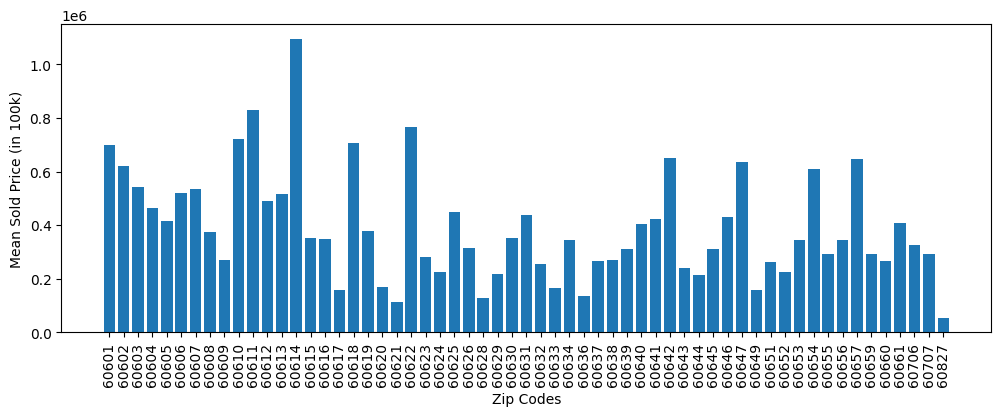

In [208]:
# zip_code vs. price
# would indicate richer zip codes

plt.figure(figsize=(12, 4))

grouped_data = df.groupby("zip_code", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["zip_code"], grouped_data["sold_price"])

plt.xticks(rotation=90)
plt.xlabel("Zip Codes")
plt.ylabel("Mean Sold Price (in 100k)")
plt.show()

The zipcodes need to be encoded.
The highest mean selling price has a zipcode of 60614, and the lowest is 60827. 

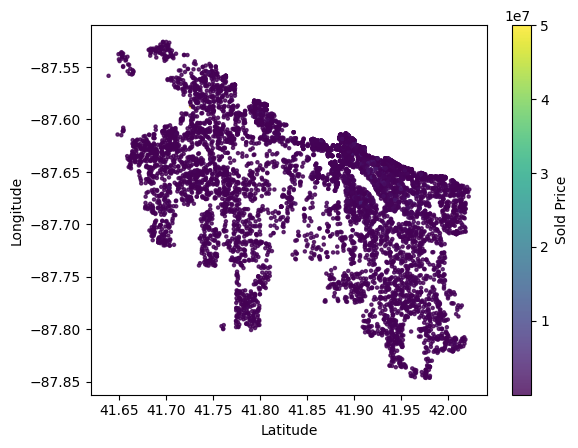

In [209]:
plt.scatter(df["latitude"], df["longitude"], c=df["sold_price"], cmap='viridis', s=5, alpha=0.8)
plt.colorbar(label='Sold Price')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

This map traces out the shape of Chicago with all of the properties mapped using price as color. It's clear the majority of properties are just less or around 10^7 dollars. This may be a better alternative than using the zipcodes, although the numbers may vary a lot compared to using the zipcodes to "bin" the coordinates.

In [210]:
# lat and long for zip

lat_long_df = pd.read_csv("zipCodeToLatLong.csv")

df.rename(columns={"latitude": "zip_lat", "longitude": "zip_long"}, inplace=True)
df['zip_code'] = df['zip_code'].astype(int)
df = df.merge(lat_long_df, left_on="zip_code", right_on="zip", how="left")

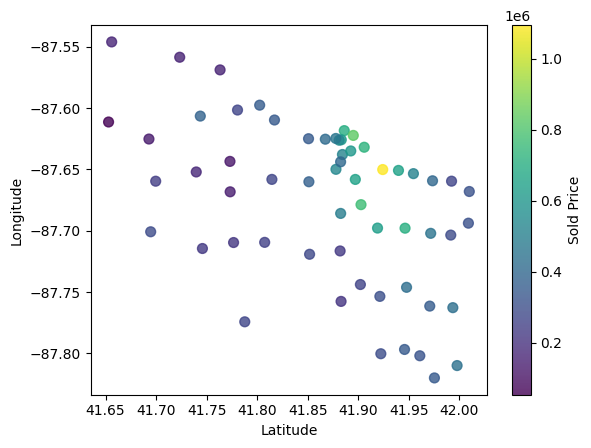

In [213]:
grouped_data = df.groupby("zip_code", as_index=False)[["sold_price", "zip_lat", "zip_long"]].mean()

plt.scatter(grouped_data["zip_lat"], grouped_data["zip_long"], c=grouped_data["sold_price"], cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label='Sold Price')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Grouping the data by zipcode gives us a clearer picture of where the richer areas of Chicago are (downtown). I still might use the raw latitudes and longitudes because they're more precise than this binning. 

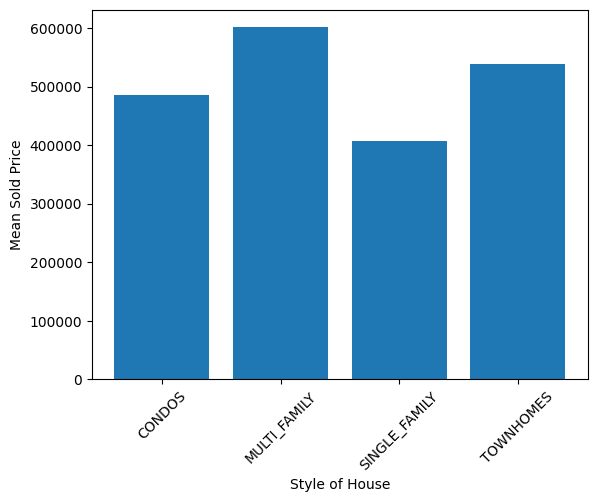

In [214]:
# style vs. price
# larger homes, pricier

grouped_data = df.groupby("style", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["style"], grouped_data["sold_price"])

plt.xticks(rotation=45)
plt.xlabel("Style of House")
plt.ylabel("Mean Sold Price")
plt.show()

The trends seem to make sense, with houses being higher than condos or single family houses. However, this metric might just be easier to figure out using the number of beds and baths.

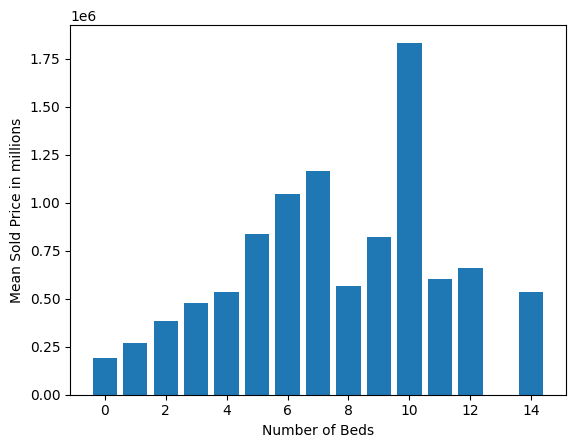

In [215]:
# beds vs. price
# more beds, higher price

grouped_data = df.groupby("beds", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["beds"], grouped_data["sold_price"])

plt.xlabel("Number of Beds")
plt.ylabel("Mean Sold Price in millions")
plt.show()

The sold price does increase and act as intended until about 7 rooms, and then it starts to go a little weird. 10 rooms has the maximum mean sold price, but 8, 11, and 14, which are all supposed to be high according to the trend, are very low, about the same price as the 5 room properties.

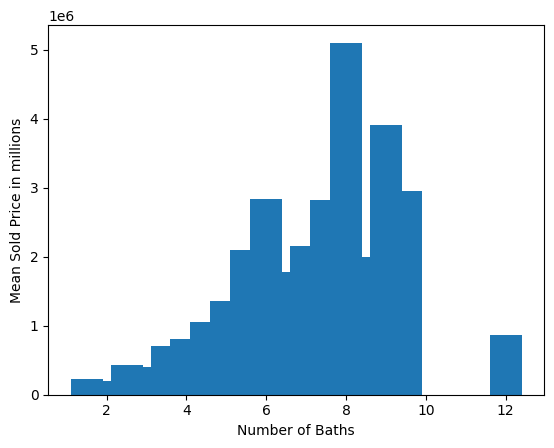

In [216]:
# baths vs. price
# more baths, higher price
df["baths"] = df["full_baths"] + (df["half_baths"] * 0.5).bfill()

grouped_data = df.groupby("baths", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["baths"], grouped_data["sold_price"])

plt.xlabel("Number of Baths")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute does mostly follow the trend of increases rooms with increasing prices. It has a peak at around 8 baths. 

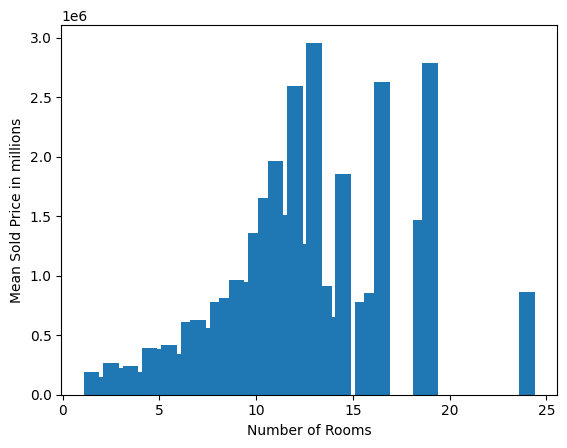

In [217]:
# combined bath + beds vs. sold price
# more rooms, higher price

df["numOfRooms"] = df["baths"] + df["beds"]

grouped_data = df.groupby("numOfRooms", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["numOfRooms"], grouped_data["sold_price"])

plt.xlabel("Number of Rooms")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This seems to follow the trend, but there are some odd lower values at some points, like at 16 and 24 rooms. Not sure why the trend doesn't apply at this higher room counts.

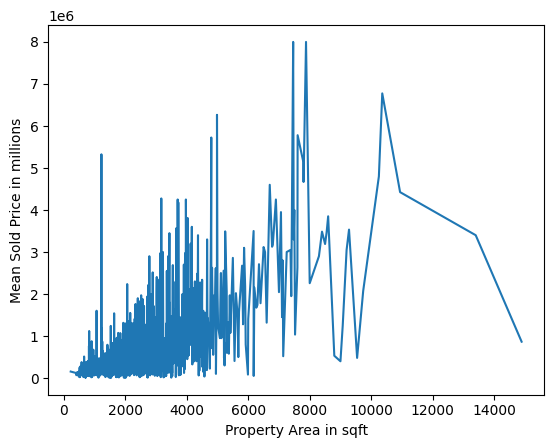

In [218]:
# sqft vs. sold price
# bigger house, higher price

grouped_data = df.groupby("sqft", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["sqft"], grouped_data["sold_price"])

plt.xlabel("Property Area in sqft")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute follows the trend as predicted. There are outliers for the properties with 15000 sqft which goes down, so it's a similar phenomenon as the bath and bed room issue of going down at extremely high values.

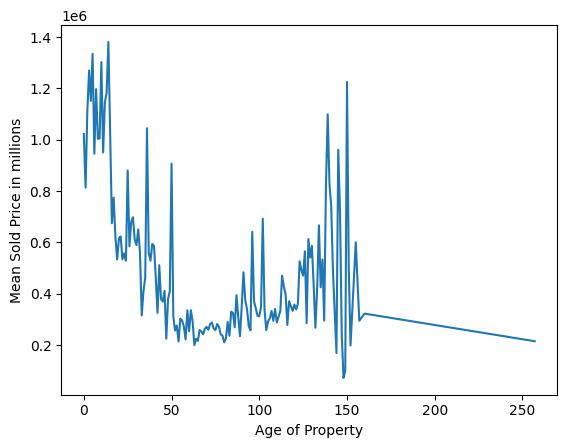

In [219]:
# age vs. sold price
# newer houses, higher price

grouped_data = df.groupby("age", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["age"], grouped_data["sold_price"])

plt.xlabel("Age of Property")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute has a lot of variation in the trend. The price is higher if the property is new, as expected, but it also seems to peak around 150 years in age, which might be able to be attributed to larger properties being older like historical buildings. 

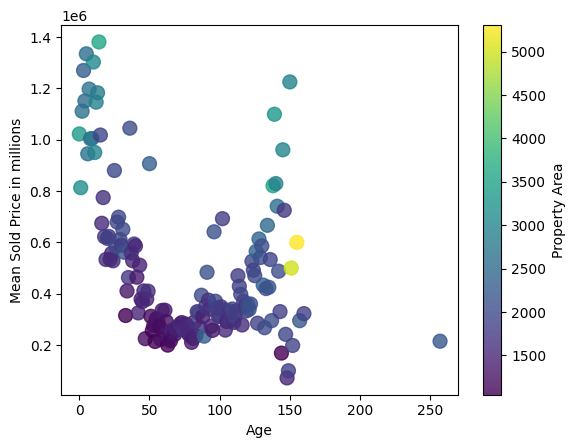

In [220]:
grouped_data = df.groupby("age", as_index=False)[["sold_price", "sqft"]].mean()

plt.scatter(grouped_data["age"], grouped_data["sold_price"], c=grouped_data["sqft"], cmap='viridis', s=100, alpha=0.8)
plt.colorbar(label='Property Area')

plt.xlabel("Age")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This second graph actually doesn't follow the trend I expected it would. There is no discernable correlation between property area and the age. Some newer properties are very large, and so are some that are around 150 years old. There is a single outlier with an age of 250 years, a medium-size area, and a low price.

# 4.Prepare the Data


Apply any data transformations and explain what and why


After looking through the statistics, I've determined the features I'll be including to maximize prediction accuracy and minimize parameter count are number of rooms, property area, age, and geographic location. Although number of rooms and property area seem to follow very similar trends, so I might be able to not use that attribute.

In [229]:
df.columns = df.columns.str.strip()

In [230]:
# i've already dropped the nans
model_df = df[["sold_price", "numOfRooms", "sqft", "age", "latitude", "longitude"]].convert_dtypes().fillna(0)
model_df.head()

,sold_price,numOfRooms,sqft,age,latitude,longitude
0,585000,4.5,1400,54,41.894742,-87.615073
1,345000,5.5,1766,77,41.946189,-87.806117
2,995000,4.5,1251,3,41.885155,-87.621512
3,420000,6.5,1788,28,41.714417,-87.555761
4,460000,4.5,1369,51,41.885155,-87.621512


I needed a way to encode the zipcodes since they are categorical but crucial to the price of a house (diff neighborhoods have diff prices), so I instead used latitude and longitude coordinates of the property. These are numerical so they should be better than doing one-hot-encoding and having way to many features, which would cause dimensionality issues (i have around 30 unique zipcodes).

In [231]:
# import scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

- Might be interesting to look at nearby school ratings
- bias deterance?

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


There are 5 models I want to try:
1. Random Forest Regressor
2. Linear Multivariate Regressor
3. Ridge/Lasso Regressor
4. Support Vector Regression
5. KNN Regressor

I will use cross validation to determine which model to use for the final product.

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [25]:
def infrence(prams):
    results = m.run(prams)
    return results 